In [185]:
import pandas as pd
import numpy as np

# RandomForst Model

In [186]:
data = pd.read_csv("Predict Price of Airline Tickets.csv")
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [187]:
data['month'] = pd.DatetimeIndex(data['Date_of_Journey']).month


In [188]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data[['Airline','Source','Destination','Additional_Info']] = data[['Airline','Source','Destination','Additional_Info']].apply(le.fit_transform)


In [189]:
word_to_number = {'1 stop': 1, '2 stops': 2, 'non-stop': 0 ,'3 stops': 3 , '4 stops': 4}
data['Total_Stops'] = data['Total_Stops'].replace(word_to_number)
data['Total_Stops'] = data['Total_Stops'].fillna(0).astype('int32')
data['Total_Stops'] = data['Total_Stops'].astype('int32')


In [190]:
data.drop(['Date_of_Journey','Dep_Time','Arrival_Time','Route'],axis = 1, inplace = True)

In [191]:
def convert_to_minutes(time_str):
    parts = time_str.split()
    total_minutes = 0
    for part in parts:
        if 'h' in part:
            hours = int(part.replace('h', ''))
            total_minutes += hours * 60
        elif 'm' in part:
            minutes = int(part.replace('m', ''))
            total_minutes += minutes
    return total_minutes
data['Duration'] = data['Duration'].apply(convert_to_minutes)


In [192]:
data.head()

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,month
0,3,0,5,170,0,8,3897,3
1,1,3,0,445,2,8,7662,1
2,4,2,1,1140,2,8,13882,9
3,3,3,0,325,1,8,6218,12
4,3,0,5,285,1,8,13302,1


In [193]:
from sklearn.model_selection import train_test_split

x = data.drop('Price', axis=1).values
y = data['Price'].values

In [194]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=10)

In [195]:
from sklearn.ensemble import RandomForestRegressor

R_F_model = RandomForestRegressor()

R_F_model.fit(x_train,y_train)

y_pred = R_F_model.predict(x_test)

In [196]:
from sklearn import metrics

MAE = metrics.mean_absolute_error(y_test,y_pred)
MAPE = metrics.mean_absolute_percentage_error(y_test,y_pred)
MSE = metrics.mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)
R2_score = metrics.r2_score(y_test,y_pred)

print(" MAE on R_f model = ",MAE)
print(" MAPE on R_f model = ",MAPE)
print(" MSE on R_f model = ",MSE)
print(" RMSE on R_f model = ",RMSE)
print(" R2_score on R_f model = ",R2_score)

 MAE on R_f model =  1285.8919446822447
 MAPE on R_f model =  0.14666684281134915
 MSE on R_f model =  6091162.177605086
 RMSE on R_f model =  2468.027993683436
 R2_score on R_f model =  0.720919944420836


In [197]:
y_mean = y.mean()

RMSE/y_mean

0.2715979507724524

([<matplotlib.axis.YTick at 0x2cfb727b1d0>,
 [Text(0, 0, 'Source'),
  Text(0, 1, 'Destination'),
  Text(0, 2, 'Total_Stops'),
  Text(0, 3, 'month'),
  Text(0, 4, 'Additional_Info'),
  Text(0, 5, 'Airline'),
  Text(0, 6, 'Duration')])

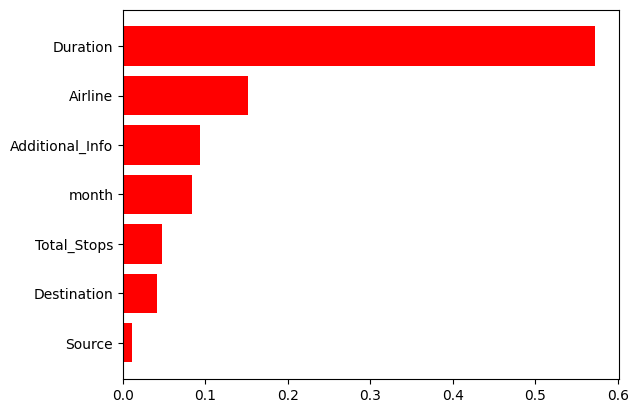

In [198]:
import matplotlib.pyplot as plt
columns_names = data.drop('Price',axis=1).columns.tolist()

importance = R_F_model.feature_importances_

indices = np.argsort(importance)

plt.barh(range(len(indices)),importance[indices], color='r')

plt.yticks(range(len(indices)), [columns_names[i] for i in indices])

# Cross validation

In [199]:
from sklearn.model_selection import KFold, cross_val_score

R_F_model = RandomForestRegressor()

cv_conf = KFold(n_splits=8, random_state=1 , shuffle=True)

scores = cross_val_score(R_F_model, x, y, cv =cv_conf , scoring='neg_root_mean_squared_error')

print(np.absolute(scores))
print(' Final score = ', np.mean(np.absolute(scores)))

[2704.41067926 1884.72127339 1958.7832513  2561.31438692 2713.42672207
 2336.8622765  2168.59955013 2401.74683504]
 Final score =  2341.233121826819


# Grid search

In [200]:
from sklearn.model_selection import GridSearchCV

Param_ranges = {
    'n_estimators': list(range(1,10)),
    'max_depth': [4,6,8,10,15,None],
    'min_samples_split':[2,3,4,5,10]
}

R_F_model = RandomForestRegressor()

g_search = GridSearchCV(estimator=R_F_model, param_grid =Param_ranges, scoring='neg_root_mean_squared_error', return_train_score=True, verbose=3  )

g_search.fit(x,y)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 1/5] END max_depth=4, min_samples_split=2, n_estimators=1;, score=(train=-2773.112, test=-3005.718) total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=2, n_estimators=1;, score=(train=-2780.468, test=-2758.070) total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=2, n_estimators=1;, score=(train=-2838.094, test=-2927.590) total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=2, n_estimators=1;, score=(train=-3007.172, test=-2896.277) total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=2, n_estimators=1;, score=(train=-2945.684, test=-3067.513) total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=2, n_estimators=2;, score=(train=-2775.122, test=-3016.055) total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=2, n_estimators=2;, score=(train=-2766.859, test=-2756.372) total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=2, n_estimators=2;, score=(trai

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 6, 8, 10, 15, None],
                         'min_samples_split': [2, 3, 4, 5, 10],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=3)

In [201]:
print('Best parameters',g_search.best_params_)
print('Best score',np.absolute(g_search.best_score_))

Best parameters {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 8}
Best score 2203.634582027856
